In [240]:
import pandas as pd
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from UKMovementSensing import hsmm

In [242]:
execfile('config.py')

## Load data

In [243]:
# Import data with states
filenames = os.listdir(states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(states_path,fn))]
datasets = [pd.read_csv(os.path.join(states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True) for fn in filenames]

print(len(datasets))

19


In [244]:
#Concatenate all data together for analysis
all_data = pd.concat(datasets)

In [245]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = all_data.state.nunique()
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [246]:
# Load simplified activities map
activities_simplified = pd.read_csv(activities_simplified_path, header=0, sep=',', dtype=str)
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]

all_data = all_data.merge(activities_simplified, left_on='label', right_on='Label', how='left')

In [247]:

heuristic_classes = ['1 - no activity',  #1
                     '2 - inactivity', #2
                     '3 - light activity', #3 
                     '4 - vigorous activity', #4
                    '5 - MVPA at least 10 min', #5
                    '6 - MVPA 1-10 min', #6
                    '7 - inactivity at least 30min'] #7 
all_data['cut-off'] = [heuristic_classes[i-1] for i in all_data['heuristic']]

## Get subjects with >20 hour data

In [248]:
all_data.columns

Index([                                      u'acceleration',
                                                       u'EN',
                                                   u'anglex',
                                                   u'angley',
                                                   u'anglez',
                                           u'roll_med_acc_x',
                                           u'roll_med_acc_y',
                                           u'roll_med_acc_z',
                                       u'dev_roll_med_acc_x',
                                       u'dev_roll_med_acc_y',
                                       u'dev_roll_med_acc_z',
                                                  u'invalid',
                                                u'heuristic',
                                                 u'filename',
                                                   u'subset',
                                             u'switched_pos',
        

In [294]:
timecounts = all_data.groupby('filename')['start_time'].count()
timecounts.name = 'cnt_5s'
timecounts['cnt_hours'] = timecounts.as_matrix() / (12.0 * 60)
timecounts

filename
__016566_2015-03-24 14-52-30.bin_day1.csv                                                 2700
__016580_2015-03-12 09-09-15.bin_day2.csv                                                 3240
__019959_2015-03-20 12-13-46.bin_day2.csv                                                 4320
__022934_2015-03-06 10-31-40.bin_day1.csv                                                17280
__022950_2015-03-12 15-57-38.bin_day1.csv                                                17280
__022950_2015-03-12 15-57-38.bin_day2.csv                                                17280
__022957_2015-03-11 12-31-53.bin_day1.csv                                                17280
__022957_2015-03-11 12-31-53.bin_day2.csv                                                13320
__022974_2015-03-04 11-02-20.bin_day1.csv                                                17280
__022974_2015-03-04 11-02-20.bin_day2.csv                                                17280
__022996_2015-03-19 12-06-23.bin_day2.csv

In [311]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
data_longdays = all_data[[(f in longdays) for f in all_data['filename']]]

## Calculate per-state statistics

In [250]:
bystate = all_data.groupby('state')
means = bystate[column_names].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

In [251]:
#Now for all columns
bystate = all_data.groupby('state')
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
means = bystate[numerical_columns].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

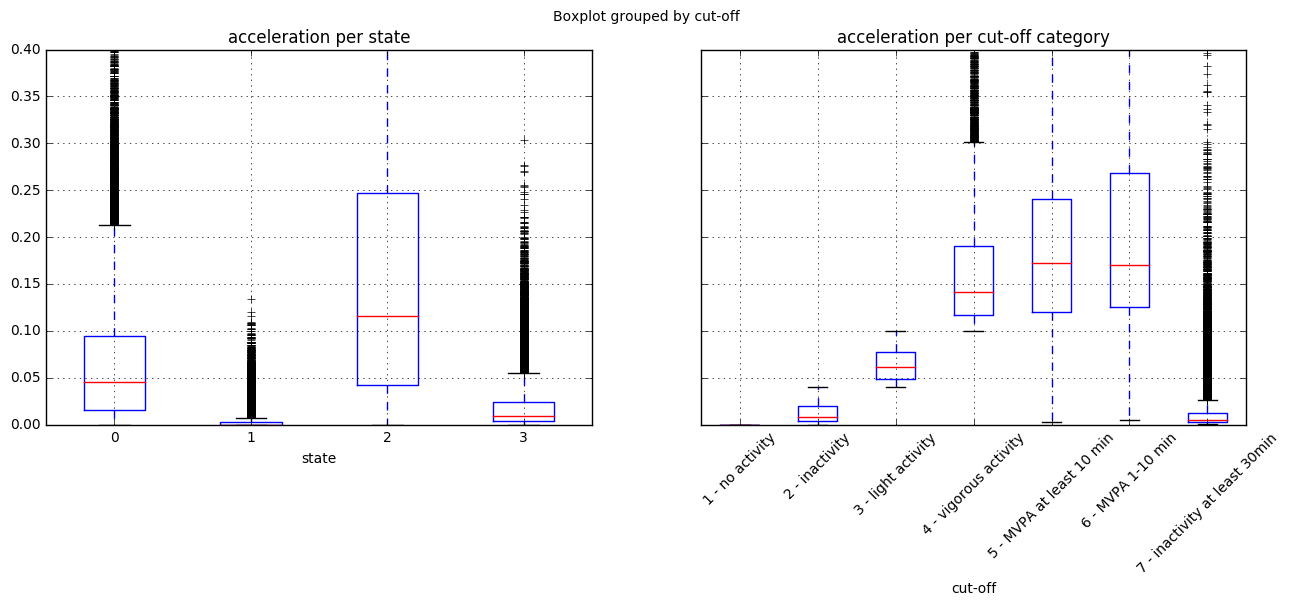

In [252]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 0.4
all_data.boxplot(by='state', column=column_names, ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].set_title('acceleration per state')
all_data.boxplot(by='cut-off', column=column_names, ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('acceleration per cut-off category')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0a6016a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd0a554a8d0>]], dtype=object)

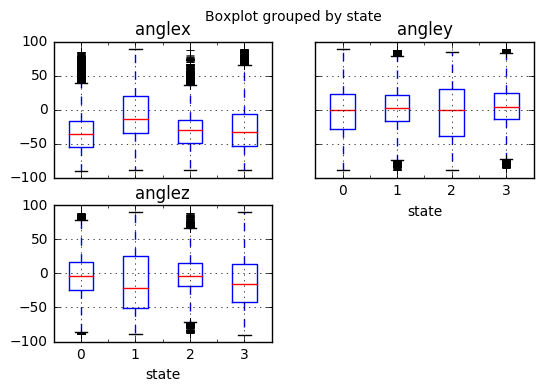

In [253]:
all_data.boxplot(by='state', column=['anglex', 'angley', 'anglez'])

## Get sojourn times

In [254]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.filename.shift(1) != df.filename)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['start_time'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'start_time']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [255]:
sojourn_times_state = sojourn_times(all_data, 'state')
sojourn_times_cutoff = sojourn_times(all_data, 'cut-off')

In [256]:
sojourn_times_cutoff.head()

,cut-off,time
0,1 - no activity,395
1,1 - no activity,297
2,1 - no activity,364
3,1 - no activity,578
4,1 - no activity,127


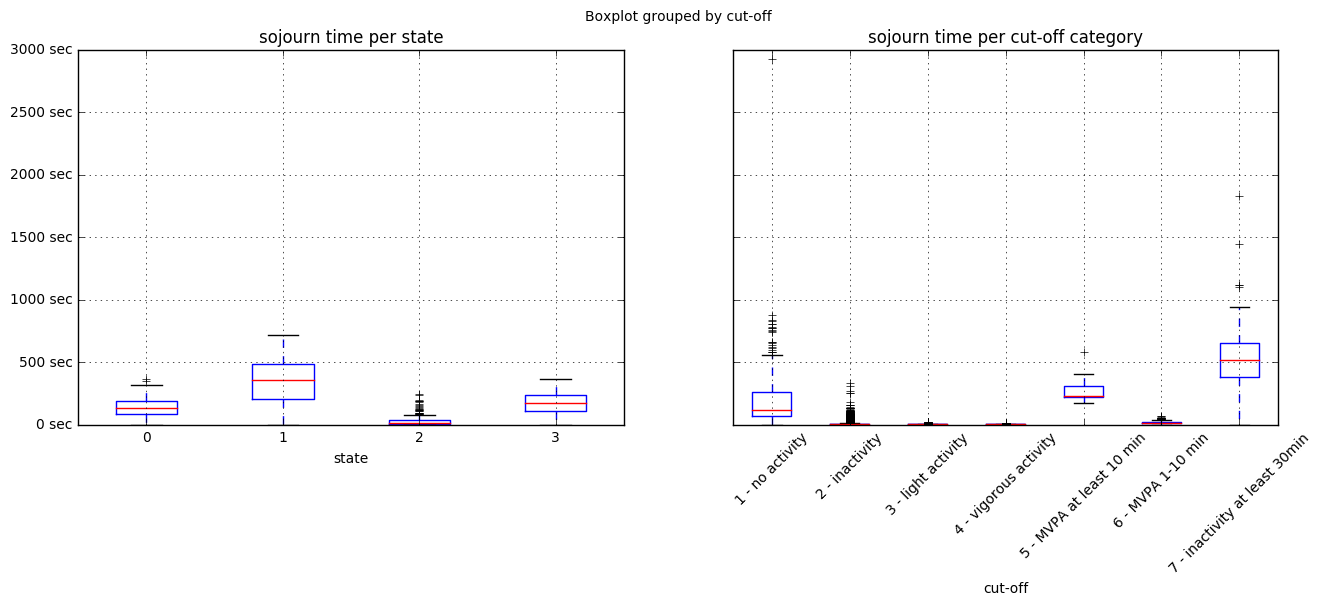

In [257]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 0.4
sojourn_times_state.boxplot(by='state', column='time', ax=axes[0])
#axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time', ax=axes[1], rot=45)
#axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [287]:
ctab = pd.crosstab(all_data['label'], all_data['state'], margins=True).sort_values('All', ascending=False)

In [259]:
all_data_sub = all_data[all_data['Keep variable']=='TRUE']

In [260]:
ctab_simplified = pd.crosstab(all_data_sub['simplified_category'], all_data_sub['state'], 
                              margins=True).sort_values('All', ascending=False)

In [261]:
ctab_simplified

state,0,1,2,3,All
simplified_category,,,,,
All,42615,104479,8001,60905,216000
"low motion, low arm changes",6707,81027,1540,12366,101640
"low motion, mixed arm changes",18860,16189,1827,31764,68640
"mixed motion, high arm changes",5376,4408,809,5967,16560
"high motion, high arm changes",6974,1409,3036,4421,15840
"low motion, high arm changes",4687,1446,646,6061,12840
"mixed motion, low arm changes",11,0,143,326,480


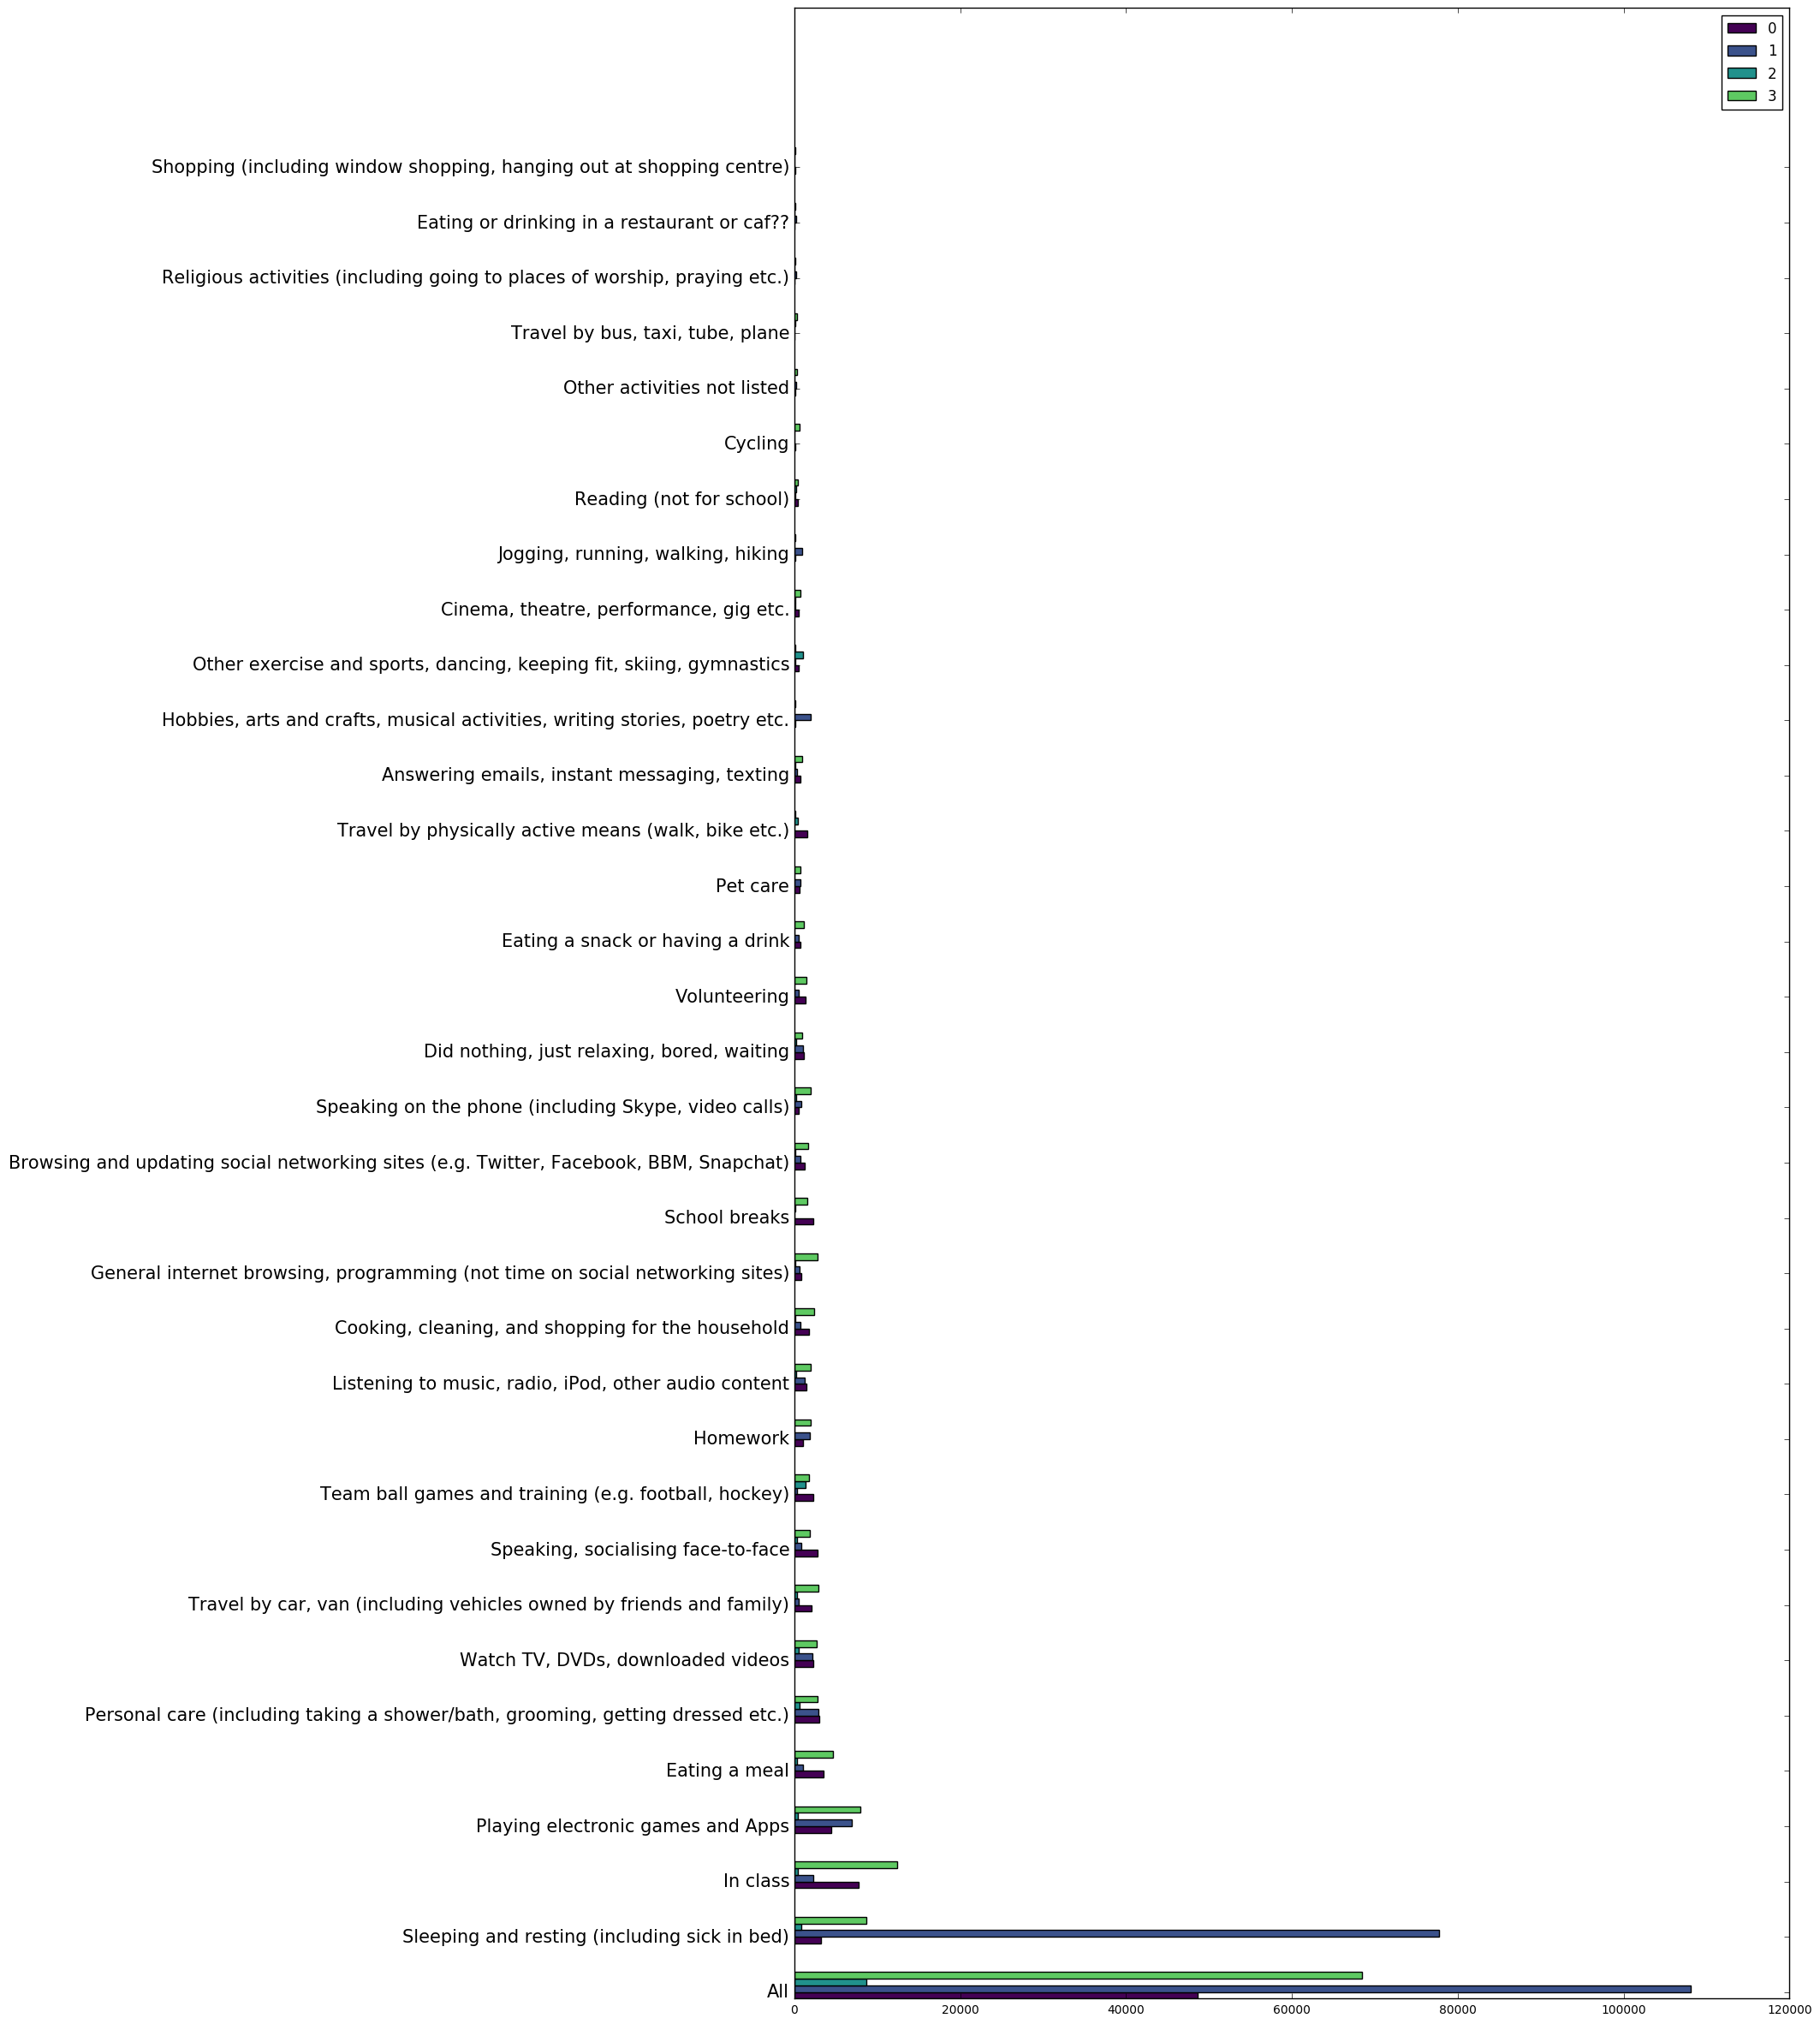

In [262]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)-1):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [263]:
#Now normalize over the activity and sort by total number
data = all_data_sub
label = 'simplified_category' #'act_label'
ind = list(ctab_simplified.index)
ctab_norm1 = pd.crosstab(data[label], data['state'], normalize='index', margins=True).loc[ind]

In [264]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [360]:
ctab_norm1.to_clipboard()

In [265]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = pd.crosstab(all_data[label], all_data['state'], normalize='columns', margins=True).loc[ind]
ctab_norm2 = ctab_norm2.fillna(0)

In [266]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

Check if there is a significant correlation between the states and the activities:

In [288]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

94157.6466218 0.0


In [289]:
ctab.head(10)

state,0,1,2,3,All
label,,,,,
All,48617,108074,8700,68489,233880
Sleeping and resting (including sick in bed),3232,77781,855,8732,90600
In class,7704,2248,469,12379,22800
Playing electronic games and Apps,4434,6915,465,7986,19800
Eating a meal,3483,1036,350,4611,9480
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",2974,2916,634,2836,9360
"Watch TV, DVDs, downloaded videos",2299,2218,479,2684,7680
"Travel by car, van (including vehicles owned by friends and family)",2052,528,366,2934,5880
"Speaking, socialising face-to-face",2778,889,336,1877,5880


In [269]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab[[a in activities for a in ctab.index]]

state,0,1,2,3,All
label,,,,,
Sleeping and resting (including sick in bed),3232,77781,855,8732,90600
"Jogging, running, walking, hiking",97,994,40,69,1200


## Compare with heuristic

In [270]:
ctab_heuristic = pd.crosstab(all_data['heuristic'], all_data['state'], margins=True)
ctab_heuristic = ctab_heuristic.fillna(0)

In [271]:
heuristic_classes = ['no activity',  #1
                     'inactivity', #2
                     'light activity', #3 
                     'moderate/vigorous activity', #4
                    'MVPA at least 10 min', #5
                    'MVPA 1-10 min', #6
                    'inactivity at least 30min'] #7 
ctab_heuristic.index = [heuristic_classes[i-1] for i in ctab_heuristic.index[:-1]] + [ctab_heuristic.index[-1]]

In [272]:
ctab_heuristic.style.background_gradient(cmap='BuGn',axis=0)

In [300]:
ctab_heuristic.applymap(lambda c: '{:.0f} min'.format(c/(12.0)))

state,0,1,2,3,All
no activity,0 min,7092 min,18 min,304 min,7414 min
inactivity,1911 min,1456 min,150 min,3477 min,6993 min
light activity,1319 min,28 min,140 min,596 min,2083 min
moderate/vigorous activity,731 min,1 min,148 min,68 min,947 min
MVPA at least 10 min,95 min,0 min,118 min,0 min,213 min
MVPA 1-10 min,255 min,0 min,209 min,0 min,464 min
inactivity at least 30min,328 min,2326 min,60 min,2063 min,4777 min
All,4638 min,10903 min,842 min,6507 min,22890 min


## Heuristic vs states, per person

In [312]:
#do this for only files with >20 hr
times = data_longdays.groupby(['filename', 'state', 'cut-off'])['start_time'].count()
times.name = 'cnt'
times = times.reset_index()

In [349]:
nr_subjects = len(times['filename'].unique())
ctab = times.groupby(['state', 'cut-off'])['cnt'].sum()
ctab = ctab / nr_subjects
ctab = ctab.unstack(level=-1)
ctab = ctab.fillna(0)
ctab['total'] = times.groupby(['state'])['cnt'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab = ctab.applymap(lambda c: '{:.0f} min'.format(c/12.0))

In [350]:
ctab

cut-off,1 - no activity,2 - inactivity,3 - light activity,4 - vigorous activity,5 - MVPA at least 10 min,6 - MVPA 1-10 min,7 - inactivity at least 30min,total
state,,,,,,,,
0,0 min,134 min,86 min,48 min,6 min,16 min,24 min,315 min
1,426 min,83 min,2 min,0 min,0 min,0 min,99 min,609 min
2,1 min,12 min,10 min,12 min,6 min,17 min,3 min,61 min
3,19 min,250 min,41 min,5 min,0 min,0 min,140 min,455 min
total,446 min,479 min,138 min,65 min,12 min,33 min,267 min,1440 min


## Distributions for the heuristic levels

In [278]:
bystate = all_data.groupby('heuristic')
means = bystate[column_names].mean().transpose()
stds = bystate[column_names].std().transpose()
concat = pd.concat([means, stds], axis=0, keys=['mean', 'sigma'])
concat = concat.reorder_levels(order=[1,0], axis=0)
concat.columns = [heuristic_classes[i-1] for i in concat.columns]
concat.style.background_gradient(cmap='coolwarm',axis=1)

In [279]:
concat.to_clipboard()

## States for an example sequence

In [280]:
example_index = 0
data = datasets[example_index]
hidden_states = data['state']

(<matplotlib.figure.Figure at 0x7fd0a51e6210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0a4f8add0>)

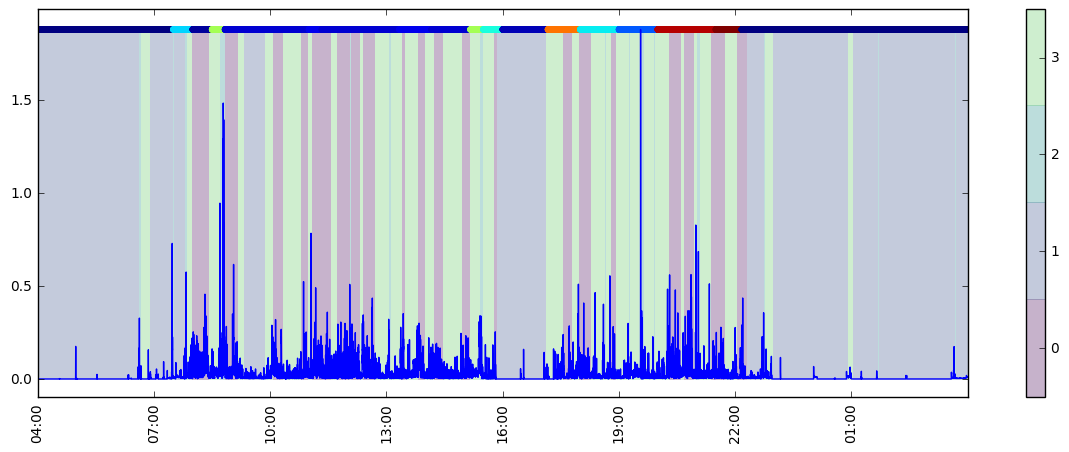

In [281]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration',], by='activity', cmap=cmap_states)

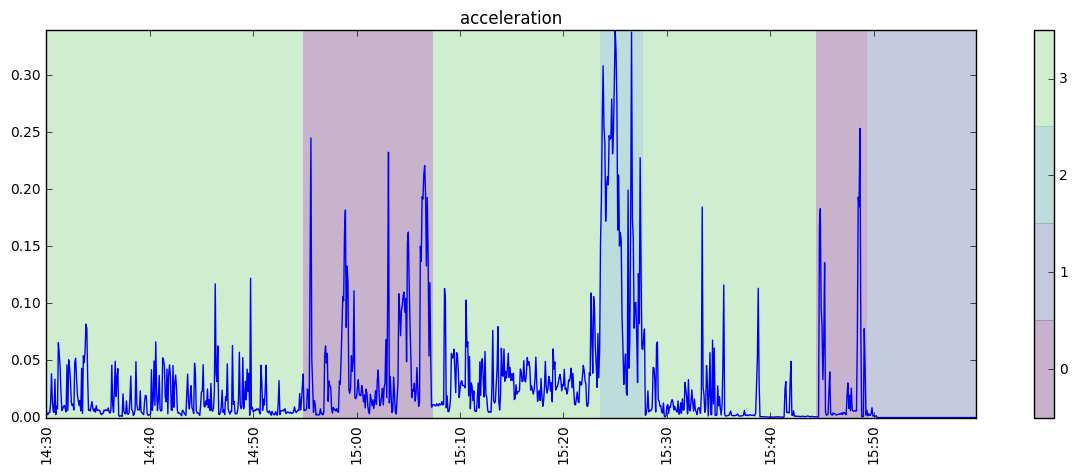

In [359]:
start =int(10.5*12*60)
end = 12*12*60
fig, ax = hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by=None)
ax.set_title('acceleration')
plt.show()

(<matplotlib.figure.Figure at 0x7fd0acf54950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0acf4acd0>)

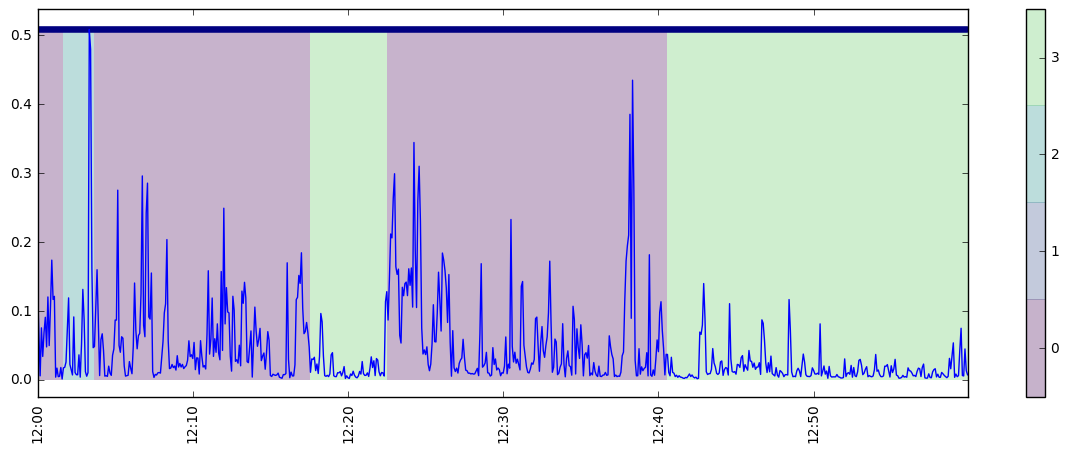

In [352]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

(<matplotlib.figure.Figure at 0x7fd0a5d07990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd0a57ec790>)

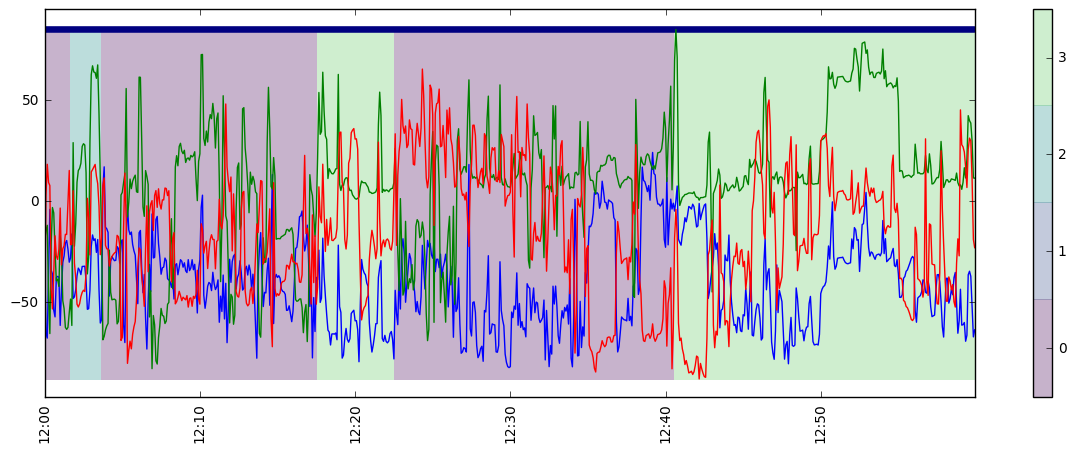

In [284]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')